In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [3]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [4]:
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.vstack((X_train,X_test)).reshape(-1,28,28,1)
y_train=np.hstack((y_train,y_test))

In [5]:
Y=np.zeros((y_train.size,y_train.max()+1),dtype=np.float32)
Y[np.arange(y_train.size),y_train]=1

In [5]:
import sys
sys.path.append("../dnn_from_scratch")

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 917
Seed: 599


In [7]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=10))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 10)                 echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        68992
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 conv

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(dropout(0.3))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.3))
    model.add(flatten())
#     model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        320
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 14, 14, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
5 BatchN

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [10]:
noise=np.random.randn(64,10).astype(np.float32)
gen=g.predict(noise)

In [11]:
X_train.shape,Y.shape

((70000, 28, 28, 1), (70000, 10))

In [12]:
def gen_sample():
    noise=Y[np.random.randint(0,Y.shape[0],1)].astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen.reshape(28,28)+1)/2, cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [13]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=Y[np.random.randint(0,Y.shape[0],batch_size)].astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
        # Train discriminator
#         y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
#         y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised output of generator as real data
        noise=Y[np.random.randint(0,Y.shape[0],batch_size)].astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%60:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).sum(),time()-stt),end='')

EPOCH: 1 / 5


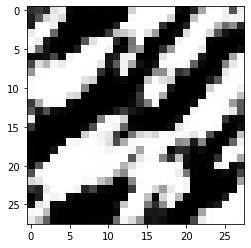

[0.47896597]
Progress: 5.39 %     Dloss: 46.11248016357422    err: 32.85149383544922     Sample time: 0.917s    ___

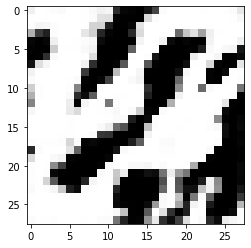

[0.5787748]
Progress: 10.88 %     Dloss: 48.19640350341797    err: 31.17167854309082     Sample time: 0.879s    _ _

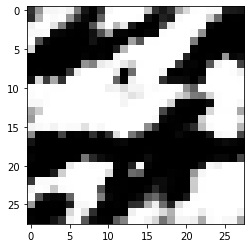

[0.41909373]
Progress: 16.37 %     Dloss: 44.44842529296875    err: 31.715444564819336     Sample time: 1.047s    __

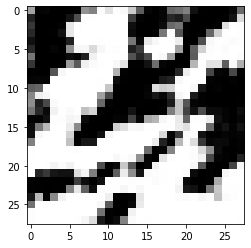

[0.42513588]
Progress: 21.85 %     Dloss: 45.257755279541016    err: 31.925216674804688     Sample time: 0.910s    _

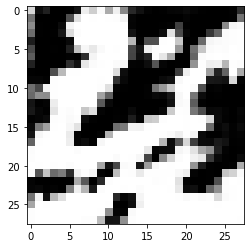

[0.44571465]
Progress: 27.34 %     Dloss: 45.6268310546875    err: 38.02568817138672     Sample time: 0.923s    ____

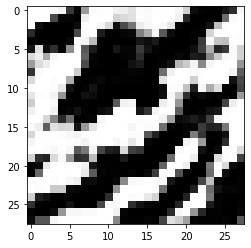

[0.60947794]
Progress: 32.82 %     Dloss: 44.929473876953125    err: 28.375202178955078     Sample time: 0.940s    _

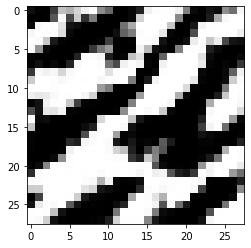

[0.44222465]
Progress: 38.31 %     Dloss: 44.720741271972656    err: 31.31125831604004     Sample time: 0.886s    __

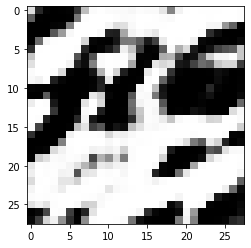

[0.5327738]
Progress: 43.79 %     Dloss: 48.16834259033203    err: 25.50566864013672     Sample time: 0.900s    ___

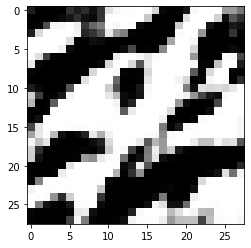

[0.68937844]
Progress: 49.28 %     Dloss: 43.6524543762207    err: 24.64411163330078     Sample time: 0.920s    _ __

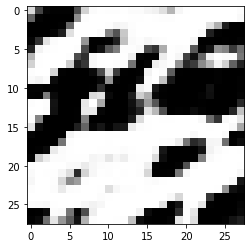

[0.56929696]
Progress: 54.77 %     Dloss: 44.74557876586914    err: 25.67392349243164     Sample time: 0.913s    ___

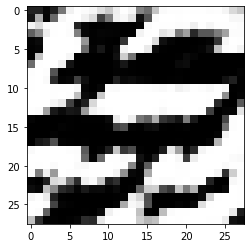

[0.4381349]
Progress: 60.25 %     Dloss: 46.01446533203125    err: 23.775135040283203     Sample time: 0.852s    __

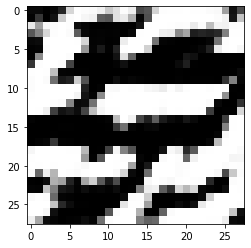

[0.4934791]
Progress: 65.74 %     Dloss: 45.79674530029297    err: 22.050317764282227     Sample time: 1.639s    __

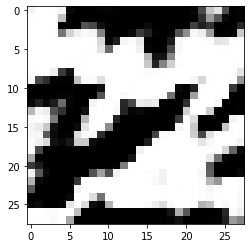

[0.55124384]
Progress: 71.22 %     Dloss: 45.59318542480469    err: 20.21819496154785     Sample time: 1.565s    ___

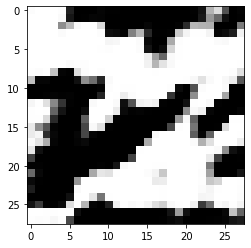

[0.49887636]
Progress: 76.71 %     Dloss: 46.25065231323242    err: 18.970863342285156     Sample time: 0.841s    __

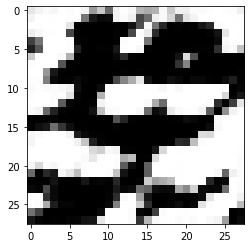

[0.42582354]
Progress: 82.19 %     Dloss: 42.192222595214844    err: 21.15877914428711     Sample time: 0.872s    __

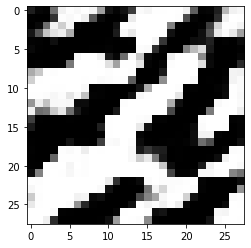

[0.5392088]
Progress: 87.68 %     Dloss: 44.250709533691406    err: 19.86713218688965     Sample time: 0.926s    __

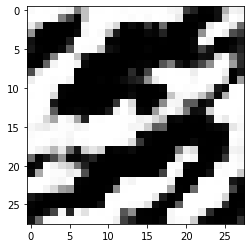

[0.5096707]
Progress: 93.17 %     Dloss: 43.90696716308594    err: 20.44369125366211     Sample time: 0.906s    ___

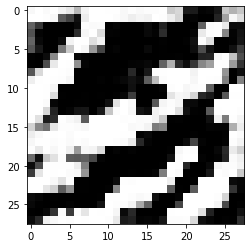

[0.54472995]
Progress: 98.65 %     Dloss: 46.73406219482422    err: 20.539793014526367     Sample time: 0.882s    __

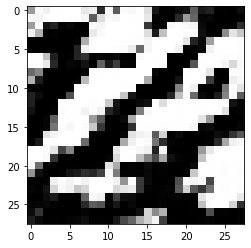

[0.5903066]
Progress: 99.84 %     Dloss: 44.810401916503906    err: 20.129661560058594     Sample time: 0.914s    _
Epoch time: 18:2s


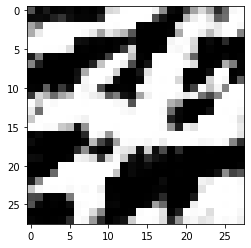

[0.6121455]
EPOCH: 2 / 5


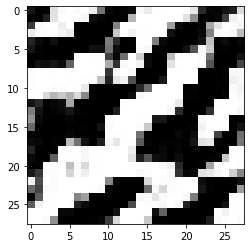

[0.71980375]
Progress: 5.39 %     Dloss: 44.26019287109375    err: 23.73346710205078     Sample time: 1.978s    ___

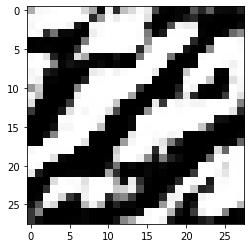

[0.45718193]
Progress: 10.88 %     Dloss: 46.26533508300781    err: 30.10207176208496     Sample time: 0.911s    ___

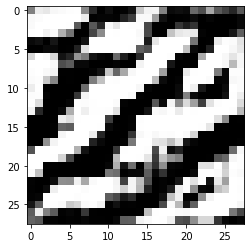

[0.4644933]
Progress: 16.37 %     Dloss: 45.94973373413086    err: 35.02683639526367     Sample time: 1.042s    ___

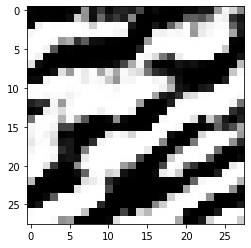

[0.5963277]
Progress: 21.85 %     Dloss: 46.10163116455078    err: 28.177461624145508     Sample time: 0.915s    __

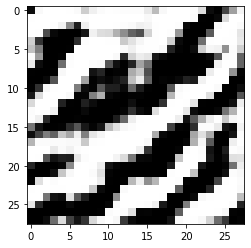

[0.48994517]
Progress: 24.59 %     Dloss: 45.04258728027344    err: 24.772218704223633     Sample time: 0.980s    __

KeyboardInterrupt: 

In [17]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

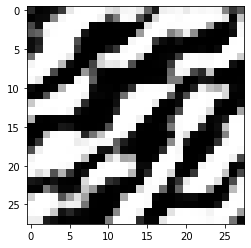

[0.4966324]


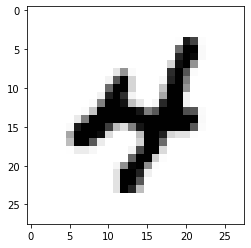

[[0.2578236]]


In [18]:
noise=np.random.randn(128,10).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img.reshape(28,28)+1)/2, cmap='Greys')
plt.show()
print(d.predict(img))

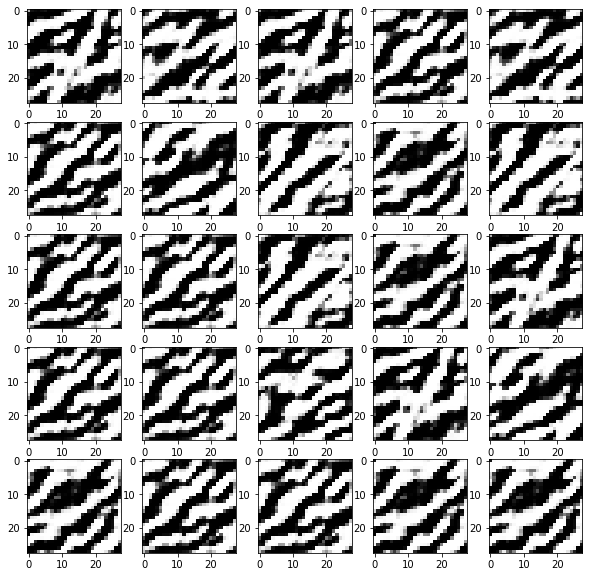

In [19]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=Y[np.random.randint(0,Y.shape[0],25)]
# noise=np.random.randn(25,10).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2, cmap='Greys')